In [ ]:
%tensorflow_version 2.x                                                       #activate TPU sakib
 
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
 
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:

""" use this for every model creation 
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  classifier = final_destination ((256,256,3,30) , )
classifier.summary()
"""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
#Run this
#!pip install albumentations > /dev/null
#!pip install -U efficientnet==0.0.4
!pip install keras_efficientnets
#%tensorflow_version 1.x
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization, Multiply, Subtract, AveragePooling2D
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils, plot_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image

seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

#tf.set_random_seed(seed)
    
%matplotlib inline

In [20]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [ ]:
#Run this
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    
# encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#middle
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', name = 'up5')(conv5)
# decoder
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name = 'up6')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name = 'up7')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'up8')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', name = 'up9')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

unet = unet()
unet.load_weights("/content/drive/My Drive/CT_SCAN_SARS-COV_2_datasets/final_unet/mosmeddata_unet/63_percent.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_16[0][0]                  
____________________________________________________________________________________________

In [ ]:
#Run this
for layer in unet.layers:
	layer.trainable = False

In [ ]:
out = unet.get_layer("up7").output  #normal u_net... decoder 64x64
model_cut_right = Model(inputs = unet.input, outputs = out)
model_cut_right.summary()

out = unet.get_layer("middle_point").output  #normal u_net... encoder 64x64
model_cut_en = Model(inputs = unet.input, outputs = out)
#model_cut_en.summary()

"""
out = backbone.layers[60].output
model_eff = Model(inputs = backbone.input, outputs = out)

for layer in model_eff.layers:
	layer.trainable = False

model_eff.summary()

"""

#plot_model(model_eff)

In [ ]:
def volume_feature_map(in_shape , filter0=256):
    x_in_0 = Input(in_shape)
    slice_num= x_in_0.shape[-1]
    print(x_in_0.shape)
    x_in = Reshape((256, 256, 3, slice_num))(x_in_0)
    
    branch = []
    for i in range(slice_num):
        x_out = Lambda(lambda x: x[:,:,:,:,i])(x_in)  
        #x_out_1 = model_eff(x_out)
        #x_out_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_out_1)
        

        x_out_2 = model_cut_right(x_out)
        x_out_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_out_2)
        #print(x_out_1.shape)
        print(x_out_2.shape)

        #while x_out_1.shape[1]!=x_out_2.shape[1]:
            #x_out_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(UpSampling2D((2,2))(x_out_1))

        #x_out_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_out_1)
        #x_out_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_out_2)
        #x_out_3 = concatenate([x_out_1, x_out_2], axis=-1)
        
        #print(x_out_1.shape)
        print(x_out_2.shape)
        branch.append(x_out_2)
        print(i)
        #if i==0: break
        
    
    x = Concatenate(axis=-1)(branch)
    
    def just_conv(new_in, filter, ker):
        new_in =  Conv2D(filter, (ker, ker), activation='relu', padding='same')(new_in)
        #new_in = BatchNormalization()(new_in)
        return new_in

    def jump_add(new_in, mode, filter):
        if mode==0:
          new_in_1 = just_conv(new_in, filter, 3)
        
        elif mode==1:
          new_in_1 = just_conv(new_in,filter,  3)
          new_in_2 = just_conv(new_in_1, filter, 3)
          new_in_2 = just_conv(new_in_2, filter, 3)
            
          new_in_1 = Add()([new_in_1, new_in_2])

        elif mode==2:
          new_in_1 = just_conv(new_in, filter, 3)
          new_in_2 = just_conv(new_in_1, filter, 3)
          new_in_2 = just_conv(new_in_2, filter,  3)

          new_in_3 = just_conv(new_in_1, filter, 1)
          new_in_3 = just_conv(new_in_3, filter, 1)
          new_in_1 = Add()([new_in_1, new_in_2, new_in_3])

        return new_in_1

    def jump_con(new_in, mode, filter):
        if mode==0:
          new_in_1 = just_conv(new_in, filter, 3)
        
        elif mode==1:
          new_in_1 = just_conv(new_in,filter,  3)
          new_in_2 = just_conv(new_in_1, filter, 3)
          new_in_2 = just_conv(new_in_2, filter, 3)
            
          new_in_1 = concatenate([new_in_1, new_in_2], axis=-1)

        elif mode==2:
          new_in_1 = just_conv(new_in, filter, 3)
          new_in_2 = just_conv(new_in_1, filter, 3)
          new_in_2 = just_conv(new_in_2, filter,  3)

          new_in_3 = just_conv(new_in_1, filter, 1)
          new_in_3 = just_conv(new_in_3, filter, 1)
          new_in_1 = concatenate([new_in_1, new_in_2, new_in_3], axis=-1)

        return new_in_1
    
    

    x = jump_add(x, mode= 0, filter = int(filter0))

    
    #complex_1
    x2=x
    x = jump_add(x, mode= 0, filter = int(filter0/2))
    x = jump_con(x, mode= 2, filter = int(filter0/2))
    x = jump_con(x, mode= 2, filter = int(filter0/4))
    x = concatenate([x, x2], axis=-1)
    #complex_1
  
    """
    #complex_2 

    x2 = jump_add(x, mode= 0, filter = int(filter0/2))
    x2 = jump_con(x2, mode= 1, filter = int(filter0/2))
    x2 = jump_con(x2, mode= 1, filter = int(filter0/4))
    x = concatenate([x, x2], axis=-1)

    #complex_2
    """


    x = GlobalAveragePooling2D()(x)    
    x = LeakyReLU(alpha=0.1) (x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)  
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(x_in_0, x)
    
    
    return model

In [ ]:
model_appended=volume_feature_map((256, 256, 3, 30), filter0=256) 

In [ ]:
model_appended.summary()

In [ ]:
plot_model(model_appended,
    to_file="model_appended.png")

In [ ]:
im_dir = "/content/drive/My Drive/CT_SCAN_SARS-COV_2_datasets/dataset/CLASSIFIER_PATIENT_WISE/train"
a1 = os.path.join(im_dir, os.listdir(im_dir)[0])
a2 = os.path.join(im_dir, os.listdir(im_dir)[1])
bunches = 250
patients = len(os.listdir(a1))+len(os.listdir(a2))

init = 0  #don't exceed 5
bunch_1= bunches/2
bunch_0= bunches/2

if (len(os.listdir(a1))-bunch_1*(init+1)) <2: 
  rest1 = int(len(os.listdir(a1))-bunch_1*(init+1))
else :
  rest1 = 0

if (len(os.listdir(a2))-bunch_0*(init+1)) <2: 
  rest2 = int(len(os.listdir(a2))-bunch_0*(init+1))
else :
  rest2 = 0

X = np.empty((bunches+rest1+rest2, 256, 256, 3, 30), dtype= np.float64)
Y = np.empty((bunches+rest1+rest2), dtype= int)

X.shape

(250, 256, 256, 3, 30)

In [ ]:
int(bunch_0*init), int(bunch_0*(init+1)+rest2)

(0, 150)

In [ ]:
#Run this
import cv2
for j in range(int(bunch_1*init), int(bunch_1*(init+1)+rest1)):
    a1_1= os.path.join(a1, os.listdir(a1)[j])  #patients
    a1_1_1= np.sort(random.sample(os.listdir(a1_1), 30))  #30 sampling
    for m in range(len(a1_1_1)):
        a111_im = os.path.join(a1_1, a1_1_1[m])
        a111_im = cv2.imread(a111_im)
        a111_im = resize(a111_im, (256, 256,3), anti_aliasing=True)
        X[j, :,:,: ,m] = a111_im
        print("patient : " + str(j) + " slice : " +str(m))
        Y[j] = 1

for j in range(int(bunch_1*(init+1)+rest1)+int(bunch_0*init),int(bunch_1*(init+1)+rest1)+int(bunch_0*(init+1)+rest2)):
    a2_1= os.path.join(a2, os.listdir(a2)[j - int(bunch_0)])  #patients
    a2_1_1= np.sort(random.sample(os.listdir(a2_1), 30))  #30 sampling
    for m in range(len(a2_1_1)):
        a211_im = os.path.join(a2_1, a2_1_1[m])
        a211_im = cv2.imread(a211_im)
        a211_im = resize(a211_im, (256, 256, 3), anti_aliasing=True)
        X[j, :,:,:,m ] = a211_im
        print("patient : " + str(j) + " slice : " +str(m))
        Y[j] = 0

Streaming output truncated to the last 5000 lines.
patient : 83 slice : 11
patient : 83 slice : 12
patient : 83 slice : 13
patient : 83 slice : 14
patient : 83 slice : 15
patient : 83 slice : 16
patient : 83 slice : 17
patient : 83 slice : 18
patient : 83 slice : 19
patient : 83 slice : 20
patient : 83 slice : 21
patient : 83 slice : 22
patient : 83 slice : 23
patient : 83 slice : 24
patient : 83 slice : 25
patient : 83 slice : 26
patient : 83 slice : 27
patient : 83 slice : 28
patient : 83 slice : 29
patient : 84 slice : 0
patient : 84 slice : 1
patient : 84 slice : 2
patient : 84 slice : 3
patient : 84 slice : 4
patient : 84 slice : 5
patient : 84 slice : 6
patient : 84 slice : 7
patient : 84 slice : 8
patient : 84 slice : 9
patient : 84 slice : 10
patient : 84 slice : 11
patient : 84 slice : 12
patient : 84 slice : 13
patient : 84 slice : 14
patient : 84 slice : 15
patient : 84 slice : 16
patient : 84 slice : 17
patient : 84 slice : 18
patient : 84 slice : 19
patient : 84 slice : 20

In [ ]:
#Run this
def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a, b

X,Y = shuffle_in_unison_scary(X,Y)

In [ ]:
from keras.callbacks import *

model_appended.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

weight_saver = ModelCheckpoint('Jahin_2_0_decoder_eff_frozen.h5', monitor='accuracy', 
                                save_best_only=True, save_weights_only=True)
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)
hist = model_appended.fit(x = X , 
                          y = Y, 
                          batch_size = 2,
                          epochs = 40,
                          callbacks = [weight_saver , annealer],
                          validation_split = 0.2,
                          shuffle = False,
                          verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [ ]:
model_appended.predict(X[28:29])

array([[1.7282919e-07]], dtype=float32)

In [ ]:
Y[28]


0

In [ ]:
X.shape

(300, 256, 256, 3, 30)

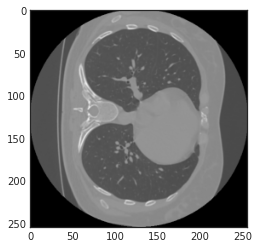

In [ ]:
plt.imshow (X[270,:,:,:,13])

In [ ]:
from keras.applications import VGG16

vgg = VGG16(include_top=False,
                  weights="imagenet",
                 input_shape=(256, 256,3))

model_vgg = Model(vgg.input, vgg.layers[10].output)

  
model_vgg.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [ ]:
#Run this
from keras.layers import Multiply


def approach_1_block(in_shape):
    x_in = Input(in_shape)
    slice_num= x_in.shape[-1]
    branch = []
    

    def trained_model_block(model, x):
        bin=[]
        for j in range(5):
           x_2 = Lambda(lambda x: x[:,:,:,j*3:(j+1)*3])(x)
           x_2 = model(x_2)      
           x_2 = GlobalAveragePooling2D()(x_2)
          
           x_2 = Dense(128, activation='relu')(x_2)  
           
           bin.append(x_2)
                  
        x_out = Concatenate(axis=-1)(bin)
        return x_out
    
    def s_e_block(in_block):
        x = GlobalAveragePooling2D()(in_block)
        x = Dense(int(in_block.shape[-1]//2), activation='relu')(x)
        x = Dense(int(in_block.shape[-1]), activation='sigmoid')(x)
        return Multiply()([in_block, x])
    
    
    def attention_block(slice_x):
        basket=[]
        for i in range(5,10):
          name = "up"+str(i)
          out = unet.get_layer(name).output
          temp_model = Model(inputs = unet.input, outputs = out)
          x2 = temp_model(slice_x)
          
          """ optional s/e block for later """
          
          #x = s_e_block(x2)          
          #x = Add()([x, x2])
          
          """ optional s/e block for later """
          
          
          x = Conv2D(64, (1,1), activation= "relu", padding="same")(x2)
          

          while x.shape[1]!= 256: x= UpSampling2D((2,2))(x)
          x = Conv2D(3, (3,3), activation= "sigmoid", padding="same")(x)
          x = Multiply()([slice_x, x])
          
          #x = model_vgg(x)
          #x = Conv2D(64, (1,1), activation= "relu", padding="same")(x)
          basket.append(x)
        x = Concatenate(axis=-1)(basket)
        
        return x
    
   

    for i in range(slice_num):
        print(i)
        x_out = Lambda(lambda x: x[:,:,:,:,i])(x_in)  
        x_out_1= attention_block(x_out)

        #x_out_1 = GlobalAveragePooling2D()(x_out_1)
        #x_out_1 = LeakyReLU(alpha=0.1) (x_out_1)
        #x_out_1 = Dropout(0.1)(x_out_1)
        
        x_out_1= trained_model_block(model_vgg, x_out_1)
        
        print(x_out_1.shape)
        x_out_1 = Dense(32, activation='relu')(x_out_1)
        
        branch.append(x_out_1)
      
    x = Concatenate(axis=-1)(branch)
    

    #x = Flatten()(x)
    x = Dense(128, activation='relu')(x)  
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    #print(x.shape)
    
    model = Model(x_in, x)

    return model


In [ ]:
#Run this
model_approach= approach_1_block((256, 256, 3, 30))


0
(?, 640)
1
(?, 640)
2
(?, 640)
3
(?, 640)
4
(?, 640)
5
(?, 640)
6
(?, 640)
7
(?, 640)
8
(?, 640)
9
(?, 640)
10
(?, 640)
11
(?, 640)
12
(?, 640)
13
(?, 640)
14
(?, 640)
15
(?, 640)
16
(?, 640)
17
(?, 640)
18
(?, 640)
19
(?, 640)
20
(?, 640)
21
(?, 640)
22
(?, 640)
23
(?, 640)
24
(?, 640)
25
(?, 640)
26
(?, 640)
27
(?, 640)
28
(?, 640)
29
(?, 640)


In [ ]:
#Run this
model_approach.summary()
#plot_model(model_approach)

Model: "model_153"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3,  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________

In [ ]:
#Run this
from keras.callbacks import *

model_approach.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

weight_saver = ModelCheckpoint('Jahin_3_0_approach_1_SE0.h5', monitor='accuracy', 
                                save_best_only=True, save_weights_only=True)
annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)
hist = model_approach.fit(x = X , 
                          y = Y, 
                          batch_size = 2,
                          epochs = 50,
                          callbacks = [weight_saver , annealer],
                          validation_split = 0.2,
                          shuffle = False,
                          verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 200 samples, validate on 50 samples
Epoch 1/50


ResourceExhaustedError: ignored

In [22]:
def jahin_activation(x):
    return (1. / (1. + K.exp(5*(x-0.5))))

In [23]:
def mse_block(x_input):  # this block takes a block of input shape (256, 256, nb_channels) )(256,256, 64)
  x_in1 = GlobalAveragePooling2D()(x_input)
  x_in1 = Dense(int(x_input.shape[-1]//4) , activation = 'relu')(x_in1)
  x_in1 = Dense(int(x_input.shape[-1]), activation = 'sigmoid')(x_in1)
  s1 = Multiply()([x_in1 , x_input])

  x_in2 = Conv2D(filters = int(x_input.shape[-1]), kernel_size = (3,3), strides = (2,2), padding = 'same')(x_input)
  x_in2 = Conv2DTranspose (filters = 1, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'sigmoid')(x_in2)
  s2 = Multiply()([x_in2 , x_input])
  

  x_in3 = GlobalAveragePooling2D()(x_input)
  x_in3 = Dense(int(x_input.shape[-1]*4) , activation = 'relu')(x_in3)
  x_in3 = Dense(int(x_input.shape[-1]), activation = 'sigmoid')(x_in3)
  s3 = Multiply()([x_in3 , x_input])

  x_in4 = Conv2DTranspose (filters = int(x_input.shape[-1]), kernel_size = (3,3), strides = (2,2), padding = 'same')(x_input)
  x_in4 = Conv2D(filters = int(x_input.shape[-1]), kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'sigmoid')(x_in4)
  s4 = Multiply()([x_in4 , x_input])

  #s1_0 =  Dense(int(x_input.shape[-1]), activation = jahin_activation)(x_in1)
  #s1_0 =  Multiply()([s1_0 , x_input])
  #s1_0 =  Conv2D(filters = int(x_input.shape[-1]), kernel_size = (1,1), strides = (1,1), padding = 'same', activation= 'relu')(s1_0)
    
  s2_0 =  Conv2D(filters = int(x_input.shape[-1]), kernel_size = (3,3), strides = (1,1), padding = 'same', activation= jahin_activation)(x_in2)
  s2_0 =  Multiply()([s2_0 , x_input])
  s2_0 =  Conv2D(filters = int(x_input.shape[-1]), kernel_size = (1,1), strides = (1,1), padding = 'same', activation= 'relu')(s2_0)
  
  #s12_0 = Concatenate() ([s1_0, s2_0])
  #s12_0 = Conv2D (filters = int(x_input.shape[-1]), kernel_size = (1,1),strides = (1,1), padding = 'same' , activation = 'relu')(s12_0)
  out = Concatenate() ([s1, s3, s2, s4])
  out = Conv2D (filters = int(x_input.shape[-1]), kernel_size = (1,1),strides = (1,1), padding = 'same' , activation = 'relu')(out)
  out = Add()([out , x_input])
  #out = Subtract()([out, s2_0])
  
  return out

In [24]:
def E_block(x_input, f):  # this block takes a block of input shape (256, 256, nb_channels) )(256,256, 64)

  s1 = Conv2D(filters = int(f*2), kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu')(UpSampling2D((2,2))(x_input))
  s1 = Conv2D(filters = int(f*2), kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu')(s1)
  s1 = Conv2D (filters = int(f*2), kernel_size = (3,3),strides = (1,1), padding = 'same' , activation = 'relu')(s1)
  s1 = Conv2D (filters = int(f), kernel_size = (1,1),strides = (1,1), padding = 'same' , activation = 'sigmoid')(s1)
  
  return s1

In [25]:
def PYRAMID(x_input): # number of channels should be power of 2
  

  track_1 = Conv2D(filters = int(x_input.shape[-1]//4), kernel_size=(1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-3))(x_input)

  track_2 = AveragePooling2D(pool_size=(2, 2) , strides=2, padding = 'same')(x_input)
  track_2 = Conv2D(filters = int(x_input.shape[-1]//4), kernel_size=(1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-3))(track_2)
  track_2 = UpSampling2D((2,2))(track_2)
  #print(track_2.shape)

  track_3 = AveragePooling2D(pool_size=(4, 4) , strides=4, padding = 'same')(x_input)
  track_3 = Conv2D(filters = int(x_input.shape[-1]//4), kernel_size=(1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-3))(track_3)
  track_3 = UpSampling2D((4,4))(track_3)
  #print(track_3.shape)

  track_4 = AveragePooling2D(pool_size=(8, 8) , strides=8 , padding = 'same')(x_input)
  track_4 = Conv2D(filters = int(x_input.shape[-1]//4), kernel_size=(1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-3))(track_4)
  track_4 = UpSampling2D((8,8))(track_4)
  #print(track_4.shape)

  x_out_1 = Concatenate(axis = -1)([track_1, track_2 , track_3, track_4, x_input])
  

  x_out_1 = Conv2D(filters = int(x_out_1.shape[-1]//2), kernel_size=(1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-3))(x_out_1)
  x_out_1 = Add()([x_input , x_out_1])
  return x_out_1

In [26]:
from keras_efficientnets import EfficientNetB5

backbone = EfficientNetB5(weights='imagenet',
                          include_top=False,
                          input_shape=(256, 256, 3))

backbone = Model(backbone.input, backbone.layers[515].output)
backbone.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_320 (Conv2D)             (None, 128, 128, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_117 (BatchN (None, 128, 128, 48) 192         conv2d_320[0][0]                 
__________________________________________________________________________________________________
swish_117 (Swish)               (None, 128, 128, 48) 0           batch_normalization_117[0][0]    
____________________________________________________________________________________________

In [27]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [28]:
def M_unet(backbone, heavier=0):
  a1 = backbone.layers[41].output   #128x128x144       |
  a2 = backbone.layers[115].output  #64x64x240         |
  a3 = backbone.layers[189].output  #32x32x384         |    <--encoder
  a4 = backbone.layers[397].output  #16x16x1056        |
  a5 = backbone.layers[-1].output   #8x8x1824          |


  
  def just_conv(x, filter_, ker=3, up=0):
      if up:  x= UpSampling2D((2,2))(x)
      x = Conv2D(filter_, (ker,ker), activation='relu', padding='same')(x)
      return x
  
  def manual_conv_up(x, sc, ker=3):
      x = Conv2D(int(x.shape[-1]//sc), (ker,ker), activation='relu', padding='same')(x)
      x= UpSampling2D((sc,sc))(x)
      return x

  factor=1
  if heavier: factor=2

  a10 = just_conv(a1, 16*factor, up=1)
  a20 = just_conv(a2, 32*factor, up=1)
  a30 = just_conv(a3, 64*factor, up=1)
  a40 = just_conv(a4, 128*factor, up=1)
  a50 = just_conv(a5, 256*factor, up=1)


  a10 = mse_block(a10)
  a20 = mse_block((a20))
  a30 = mse_block((a30))
  a40 = mse_block((a40))
  a50 = mse_block((a50))
  
  b6 = just_conv(a5, 256*factor)                                    #           |            
  b6 = just_conv(b6, 256*factor, up=1)

  b5 = concatenate([b6,a50], axis=-1)                               #           |
  b5 = just_conv(b5, 256*factor)
  b5 = just_conv(b5, 256*factor)

  b4 = concatenate([just_conv(b5, 256*factor, up=1), a40], axis=-1) #           |
  b4 = just_conv(b4, 128*factor)
  b4 = just_conv(b4, 128*factor)

  b3 = concatenate([just_conv(b4, 128*factor, up=1), a30], axis=-1) #           |  <--decoder
  b3 = just_conv(b3, 64*factor)
  b3 = just_conv(b3, 64*factor)

  b2 = concatenate([just_conv(b3, 64*factor, up=1), a20], axis=-1)  #           |
  b2 = just_conv(b2, 32*factor)
  b2 = just_conv(b2, 32*factor)

  b1 = concatenate([just_conv(b2, 32*factor, up=1), a10], axis=-1)  #           |
  b1 = just_conv(b1, 16*factor)
  b1 = just_conv(b1, 16*factor)                                     #           |

  b10 = mse_block((b1))
  b20 = mse_block((b2))
  b30 = mse_block((b3))
  b40 = mse_block((b4))
  b50 = mse_block((b5))

  b10 = just_conv(b10, filter_=16, ker=1)

  b20 = just_conv(b20, filter_=16, ker=1)
  b20 = UpSampling2D((2,2))(b20)

  b30 = just_conv(b30, filter_=16, ker=1)
  b30 = UpSampling2D((4,4))(b30)

  b40 = just_conv(b40, filter_=16, ker=1)
  b40 = UpSampling2D((8,8))(b40)

  b50 = just_conv(b50, filter_=16, ker=1)
  b50 = UpSampling2D((16,16))(b50)

  b_all = concatenate([b10, b20, b30, b40, b50], axis=-1)

  #RIGHT
  a10 = just_conv(a10, filter_=16, ker=1)

  a20 = just_conv(a20, filter_=16, ker=1)
  a20 = UpSampling2D((2,2))(a20)

  a30 = just_conv(a30, filter_=16, ker=1)
  a30 = UpSampling2D((4,4))(a30)

  a40 = just_conv(a40, filter_=16, ker=1)
  a40 = UpSampling2D((8,8))(a40)

  a50 = just_conv(a50, filter_=16, ker=1)
  a50 = UpSampling2D((16,16))(a50)

  a_all = concatenate([a10, a20, a30, a40, a50], axis=-1)
    
  a_b = concatenate([a_all, b_all], axis=-1)
  
  
  out = Conv2D(1, (1, 1), activation='sigmoid')(a_b)
  
  #out = Conv2D(1, (1, 1), activation='sigmoid')(b1)

  model= Model(backbone.input, out)

  #print(a0_12.shape)
  #print(a02.shape)
  #print(a03.shape)
  #print(a04.shape)
  #print(a05.shape)
  return model



m_unet= M_unet(backbone,0)
m_unet.compile(optimizer=Adam(lr=1.5e-3), loss='binary_crossentropy', metrics=[dice_coef])
#m_unet.load_weights ('/content/drive/My Drive/Data/m_unet_jahin_custAct_rpp+_mse_80by20_10.h5')

In [29]:
m_unet.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_320 (Conv2D)             (None, 128, 128, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_117 (BatchN (None, 128, 128, 48) 192         conv2d_320[0][0]                 
__________________________________________________________________________________________________
swish_117 (Swish)               (None, 128, 128, 48) 0           batch_normalization_117[0][0]    
____________________________________________________________________________________________

In [31]:
#To train m_unet

source_path = '/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/archive'
mask_path = '/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/archive'


def my_generator(batch_size):
    data_generator = ImageDataGenerator(
            rescale = 1./255,
            shear_range = 0,
            zoom_range = 0,
            horizontal_flip = False).flow_from_directory(directory = source_path,
                                                                                target_size = (256,256),
                                                                                color_mode = 'rgb',
                                                                                classes = ['sources'],
                                                                                class_mode = None,
                                                                                batch_size = batch_size,
                                                                                seed = 1,
                                                                                shuffle = True)
    mask_generator = ImageDataGenerator(
            rescale = 1./255,
            shear_range = 0,
            zoom_range = 0,
            horizontal_flip = False).flow_from_directory(directory = mask_path,
                                                                                target_size = (256,256),
                                                                                color_mode = 'grayscale',
                                                                                classes = ['masks1'],
                                                                                class_mode = None,
                                                                                batch_size = batch_size,
                                                                                seed = 1,
                                                                                shuffle = True)
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch



source_path_val = '/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/archive'
mask_path_val = '/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/archive'

def my_generator_val(batch_size):
    data_generator = ImageDataGenerator(
            rescale = 1./255,
            shear_range = 0,
            zoom_range = 0,
            horizontal_flip = False).flow_from_directory(directory = source_path_val,
                                                                                target_size = (256,256),
                                                                                color_mode = 'rgb',
                                                                                classes = ['sources'],
                                                                                class_mode = None,
                                                                                batch_size = batch_size,
                                                                                seed = 1,
                                                                                shuffle = True,)
    mask_generator = ImageDataGenerator(
            rescale = 1./255,
            shear_range = 0,
            zoom_range = 0,
            horizontal_flip = False).flow_from_directory(directory = mask_path_val,
                                                                                target_size = (256,256),
                                                                                color_mode = 'grayscale',
                                                                                classes = ['masks1'],
                                                                                class_mode = None,
                                                                                batch_size = batch_size,
                                                                                seed = 1,
                                                                                shuffle = True)
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch

In [32]:
from keras.callbacks import *

weight_saver = ModelCheckpoint('/content/drive/My Drive/CT_SCAN_SARS-COV_2/dataset/archive/weight', 
                               monitor='dice_coef',mode ='max',
                               save_best_only=True, save_weights_only=True,)

annealer = ReduceLROnPlateau(monitor='dice_coef', factor=0.5,
                              patience=5, min_lr=0.00001)

hist = m_unet.fit_generator(my_generator(2),
                           steps_per_epoch = 256,
                           validation_data = my_generator_val(2), 
                           validation_steps= 160,                          
                           epochs=180, verbose=1, 
                           callbacks = [weight_saver , annealer]
                           )

Epoch 1/180
Found 1261 images belonging to 1 classes.
Found 1261 images belonging to 1 classes.
Found 1261 images belonging to 1 classes.
Found 1261 images belonging to 1 classes.
256/256 [==============================] - 484s 2s/step - loss: 0.1289 - dice_coef: 0.1082 - val_loss: 0.0107 - val_dice_coef: 0.0155
Epoch 2/180
256/256 [==============================] - 304s 1s/step - loss: 0.0098 - dice_coef: 0.0116 - val_loss: 0.0048 - val_dice_coef: 0.0121
Epoch 3/180
 98/256 [==========>...................] - ETA: 2:10 - loss: 0.0100 - dice_coef: 0.0116

KeyboardInterrupt: ignored